In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [6]:
class DoublePendulum:
    
    def __init__(self, m1=1.0, m2=1.0, l1=1.0, l2=1.0, g=9.81):
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.g = g
    
    def q_prime(self, q, r, u, v, t):
        val = u
        return val

    def r_prime(self, q, r, u, v, t):
        val = v
        return val

    def u_prime(self, q, r, u, v, t):
        m1, m2, l1, l2, g = self.m1, self.m2, self.l1, self.l2, self.g
        
        num = \
            2 * g * m1 * np.sin(q) + \
            g * m2 * np.sin(q) + \
            g * m2 * np.sin(q - 2 * r) + \
            l1 * m2 * u ** 2 * np.sin(2 * (q - r)) + \
            2 * l2 * m2 * v ** 2 * np.sin(q - r)

        den = -2 * l1 * (m1 - m2 * np.cos(q - r) ** 2 + m2)
        val = num / den
        return val

    def v_prime(self, q, r, u, v, t):
        m1, m2, l1, l2, g = self.m1, self.m2, self.l1, self.l2, self.g
        
        num = \
            -(m1 + m2) * (g * np.sin(r) - l1 * u ** 2 * np.sin(q - r)) + \
            (np.cos(q - r)) * \
                (g * m1 * np.sin(q) + \
                 g * m2 * np.sin(q) + \
                 l2 * m2 * v ** 2 * np.sin(q - r))

        den = l2 * (m1 - m2 * np.cos(q - r) ** 2 + m2)
        val = num / den
        return val
    
    def derivatives(self, q, r, u, v, t):
        args = (q, r, u, v, t)
        qruv_prime = np.array([
            self.q_prime(*args),
            self.r_prime(*args),
            self.u_prime(*args),
            self.v_prime(*args),
        ])
        return qruv_prime

    def x1(self, q, r):
        val = +self.l1 * np.sin(q)
        return val

    def y1(self, q, r):
        val = -self.l1 * np.cos(q)
        return val

    def x2(self, q, r):
        val = self.x1(q, r) + self.l2 * np.sin(r)
        return val

    def y2(self, q, r):
        val = self.y1(q, r) - self.l2 * np.cos(r)
        return val
    
    def positions(self, q, r):
        args = (q, r)
        vals = np.array([
            self.x1(*args),
            self.y1(*args),
            self.x2(*args),
            self.y2(*args),
        ])
        return vals

In [7]:
class Simulator:
    
    def __init__(self, pendulum, q0=0, r0=0, u0=0, v0=0, t0=0, h=0.05, T=15):
        self.pendulum = pendulum
        self._init_state = np.array([q0, r0, u0, v0, t0])
        self.t = np.mgrid[t0 : T : h]
        self.h = h
    
    def _get_state(self, qruvti):
        q, r, u, v, t = qruvti
        state = [*self.pendulum.positions(q, r), q, r, t]
        return state
    
    def simulate(self):
        history = []
        qruvti = self._init_state
        
        h = self.h
        f = self.pendulum.derivatives
        
        for ti in self.t:
            history += [self._get_state(qruvti)]
            k1 = h * f(*qruvti)

            offset = 0.5 * np.array([*k1, h])
            k2 = h * f(*(qruvti + offset))

            offset = 0.5 * np.array([*k2, h])
            k3 = h * f(*(qruvti + offset))

            offset = 1.0 * np.array([*k3, h])
            k4 = h * f(*(qruvti + offset))

            offset = np.concatenate((1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4), (h,)))
            qruvti = qruvti + offset
        
        history = np.array(history)
        return history

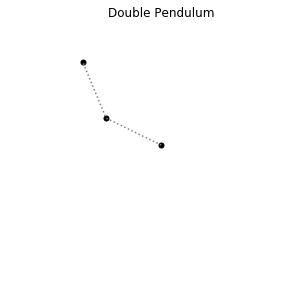

In [8]:
def get_savepath(title):
    fname = title.lower().replace(' ', '_')
    savepath = f'../images/{fname}.gif'
    return savepath


def get_limits():
    min_vals = [-2, -2]
    max_vals = [2, 2]
    limits = np.vstack((min_vals, max_vals))
    return limits.T


def configure_axes(ax, title, limits):
    ax.set_title(title)
    ax.set_xlim(limits[0, :])
    ax.set_ylim(limits[1, :])
    ax.set_aspect('equal')
    ax.set_axis_off()


class Plotter:
    '''Maintains state for FuncAnimation'''
    
    def __init__(self, state, title, incr):
        self.state = state
        self.incr = incr
        self.title = title
        self.fig, self.ax = plt.subplots()

    def init_ani(self):
        limits = get_limits()
        configure_axes(self.ax, self.title, limits)
        self.masses = self.ax.scatter([], [], s=25, c='black')
        self.arms, = self.ax.plot([], [], c='grey', linestyle='dotted')
        return self.masses, self.arms
    
    def step(self, frame):
        index = self.incr * frame
        xy = self.state[index, :4].reshape(2, 2)
        xy = np.concatenate((np.zeros((1, 2)), xy), axis=0)
        self.masses.set_offsets(xy)
        self.arms.set_xdata(xy[:, 0])
        self.arms.set_ydata(xy[:, 1])
        return self.masses, self.arms
    
    def animate(self, savepath):
        num_points = len(self.state)
        frames = num_points // self.incr

        kwargs1 = dict(fig=self.fig, func=self.step, init_func=self.init_ani)
        kwargs2 = dict(frames=frames, interval=50, repeat=False, blit=True)

        ani = FuncAnimation(**kwargs1, **kwargs2)
        ani.save(savepath, dpi=80, writer='imagemagick')
        
def main():
    q0 = np.deg2rad(175)
    r0 = np.deg2rad(175)

    pendulum = DoublePendulum()
    simulator = Simulator(pendulum, q0=q0, r0=r0)
    history = simulator.simulate()

    title = 'Double Pendulum'
    plotter = Plotter(history, title, incr=1)
    savepath = get_savepath(title)
    plotter.animate(savepath)

main()

In [238]:
from sympy import Function, solve, cos, sin, symbols, diff
from sympy import init_printing
init_printing()

t = symbols('t')
m1, m2, l1, l2, g = symbols('m1 m2 l1 l2 g')

theta1 = Function('theta1')(t)
theta2 = Function('theta2')(t)

x1 = l1 * sin(theta1)
y1 = -l1 * cos(theta1)

x2 = x1 + l2 * sin(theta2)
y2 = y1 - l2 * cos(theta2)

d2x1 = x1.diff(t, 2)
d2y1 = y1.diff(t, 2)

d2x2 = x2.diff(t, 2)
d2y2 = y2.diff(t, 2)

LHS = -cos(theta1) * (m1 * d2x1 + m2 * d2x2)
RHS = sin(theta1) * (m1 * d2y1 + m2 * d2y2 + m2 * g + m1 * g)
eqn_1 = LHS - RHS

LHS = cos(theta2) * m2 * d2x2
RHS = -sin(theta2) * (m2 * g + m2 * d2y2)
eqn_2 = LHS - RHS

system = [eqn_1, eqn_2]
soln = solve(system, theta1.diff(t, 2), theta2.diff(t, 2))

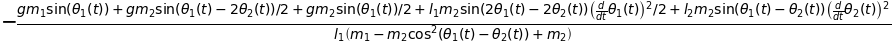

In [240]:
soln[theta1.diff(t, 2)]

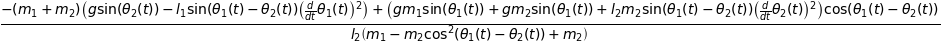

In [241]:
soln[theta2.diff(t, 2)]